In [48]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore")

In [49]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [275]:
query1=''' 
    select o.id as order_id,
    o.created_at::date as order_date,
    o.customer_id as user_id,
    o.total_line_items_price as MRP,
    o.total_discounts as discount_amount

    from orders o
    WHERE
    cancelled_at is NULL;
'''

In [276]:
query2=''' 
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

In [277]:
o=pd.read_sql(query1,conn)

In [278]:
r=pd.read_sql(query2,conn)

In [279]:
data=pd.merge(o,r,on='order_id',how='left')
data['order_id'].nunique()

72873

In [280]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95221 entries, 0 to 95220
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         95221 non-null  int64  
 1   order_date       95221 non-null  object 
 2   user_id          85588 non-null  float64
 3   mrp              95221 non-null  float64
 4   discount_amount  95221 non-null  float64
 5   product_id       95108 non-null  float64
 6   product_name     95221 non-null  object 
 7   quantity         95221 non-null  int64  
 8   sp               95221 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 6.5+ MB


In [281]:
data['order_id'].nunique()

72873

In [282]:
data['order_date']=pd.to_datetime(data['order_date'])

In [283]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel



# data = data[data['order_date'] >= '2023-01-01']
# data=data[data['order_date']<='2023/12/31']

data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1


#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()


In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95221 entries, 0 to 95220
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         95221 non-null  int64         
 1   order_date       95221 non-null  datetime64[ns]
 2   user_id          85588 non-null  float64       
 3   mrp              95221 non-null  float64       
 4   discount_amount  95221 non-null  float64       
 5   product_id       95108 non-null  float64       
 6   product_name     95221 non-null  object        
 7   quantity         95221 non-null  int64         
 8   sp               95221 non-null  float64       
 9   TrxnRank         85588 non-null  float64       
 10  New              95221 non-null  int64         
 11  Repeat           95221 non-null  int64         
 12  ordervalue       95221 non-null  float64       
 13  AOVContribution  95221 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int6

In [285]:
data['discount_ratio'] = data['discount_amount']/data['mrp']
data

,order_id,order_date,user_id,mrp,discount_amount,product_id,product_name,quantity,sp,TrxnRank,New,Repeat,ordervalue,AOVContribution,discount_ratio
0,5341764845706,2023-12-08,6.377996e+12,299.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,2.0,0,1,299.0,0.004103,0.00000
1,5341763338378,2023-12-08,6.935222e+12,199.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.002731,0.00000
2,5341750689930,2023-12-08,6.704616e+12,598.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,2,299.0,3.0,0,1,598.0,0.008206,0.00000
3,5341738500234,2023-12-08,6.935186e+12,299.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,1.0,1,0,299.0,0.004103,0.00000
4,5341737910410,2023-12-08,6.801344e+12,299.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,6.0,0,1,299.0,0.004103,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95216,5294855258250,2023-11-22,6.906591e+12,639.0,176.0,5.321621e+12,South Indian Traditional Filter Coffee - Mediu...,1,440.0,1.0,1,0,440.0,0.006038,0.27543
95217,5294417412234,2023-11-22,6.906403e+12,199.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.002731,0.00000
95218,5288648540298,2023-11-21,6.905086e+12,199.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.002731,0.00000
95219,5288405631114,2023-11-21,6.903816e+12,299.0,0.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,1.0,1,0,299.0,0.004103,0.00000


In [286]:
data['new_ordervalue']= data['ordervalue']-(data['ordervalue']*data['discount_ratio'])

In [287]:
data[data['mrp'] != data['ordervalue']]

,order_id,order_date,user_id,mrp,discount_amount,product_id,product_name,quantity,sp,TrxnRank,New,Repeat,ordervalue,AOVContribution,discount_ratio,new_ordervalue
6,5341713137802,2023-12-08,5.185704e+12,3660.0,1464.0,5.411502e+12,Tangerine: Orange Fermented Coffee - Espresso ...,1,630.0,8.0,0,1,630.0,0.008645,0.400000,378.000000
7,5341713137802,2023-12-08,5.185704e+12,3660.0,1464.0,5.411503e+12,Annanas: PineApple Fermented Coffee - Espresso...,1,630.0,8.0,0,1,630.0,0.008645,0.400000,378.000000
8,5341713137802,2023-12-08,5.185704e+12,3660.0,1464.0,5.321648e+12,Single Malt Whiskey Barrel Aged Coffee - Home ...,1,1200.0,8.0,0,1,1200.0,0.016467,0.400000,720.000000
9,5341713137802,2023-12-08,5.185704e+12,3660.0,1464.0,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,1,1200.0,8.0,0,1,1200.0,0.016467,0.400000,720.000000
19,4958665179274,2023-01-08,6.422043e+12,2530.0,0.0,6.592591e+12,Honey & Caramel Blend - 250 gm / Whole Beans,1,630.0,1.0,1,0,630.0,0.008645,0.000000,630.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95166,5377371570314,2024-01-03,5.689156e+12,1135.0,550.0,5.320258e+12,Thippanahalli Estate Coffee - French Press / 2...,1,585.0,3.0,0,1,585.0,0.008028,0.484581,301.519824
95167,5377323434122,2024-01-03,6.812024e+12,848.0,0.0,7.716186e+12,Colombian Speciality Instant Coffee - 100 gm,1,399.0,4.0,0,1,399.0,0.005475,0.000000,399.000000
95168,5377323434122,2024-01-03,6.812024e+12,848.0,0.0,7.737857e+12,Ethiopia Speciality Instant Coffee | Free Maso...,1,449.0,4.0,0,1,449.0,0.006161,0.000000,449.000000
95215,5294855258250,2023-11-22,6.906591e+12,639.0,176.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.002731,0.275430,144.189358


In [288]:
totalcarts=data['order_id'].nunique()
product_level=data.groupby(['product_name']).agg(
        Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
        ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
        NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
        RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
        Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        Total_Order_Value=pd.NamedAgg(column='new_ordervalue', aggfunc='sum'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique')
).reset_index()
produser=data.groupby(['product_name','user_id']).agg(
    New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
).reset_index()
produser_newcount=produser.groupby('product_name').agg(
    New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
).reset_index()
data_repeat=data[data['TrxnRank']==2]
produser_repeatcount=data_repeat.groupby('user_id').agg(
    Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
).reset_index()
k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
k.fillna(0)
k1=k.groupby('product_name').agg(
    Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
).reset_index()


In [289]:
product_level

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count
0,Aerolatte Steam Free Milk Frother To-Go with S...,3,3,1700.000000,2,1,3,0.069985,5100.000000,3
1,Aerolatte Steam Free Milk Frother With Stand -...,22,22,1950.000000,17,5,21,0.588695,40542.626806,22
2,Aerolatte Steam Free Milk Frother With Stand -...,6,6,2016.666667,3,3,6,0.166042,11177.539273,6
3,Aeropress Coffee Maker,18,18,3816.666667,14,4,18,0.942736,65998.607480,18
4,Aeropress Filter Paper,3,3,520.000000,3,0,3,0.021407,1560.000000,3
...,...,...,...,...,...,...,...,...,...,...
921,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,510,534,490.000000,414,100,483,3.590630,134953.385165,510
922,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,196,235,650.000000,87,111,176,2.096112,80881.910659,196
923,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,15,18,1300.000000,9,6,15,0.321107,11841.270732,15
924,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,41,42,1509.523810,36,6,41,0.870007,51983.821962,41


In [290]:
productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
productlevel['NewRepeatConversionRatio'].fillna(0)
productlevel=productlevel.sort_values('NewRepeatConversionRatio')
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [291]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,New_count,Repeat_count,NewRepeatConversionRatio,CartPenetration,QpC,ASPXQpC
925,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,1,1,1650.0,1,0,1,0.022642,1650.000000,1,1.0,0.0,0.0,0.000014,1.0,1650.0
109,Baba Budangiri Estate Coffee - Turkish Coffee ...,1,1,2200.0,1,0,1,0.030190,880.000000,1,1.0,0.0,0.0,0.000014,1.0,2200.0
735,Single Malt Whiskey Barrel Aged Coffee - Turki...,7,7,2544.0,7,0,7,0.244370,12251.400000,7,7.0,0.0,0.0,0.000096,1.0,2544.0
726,Single Malt Whiskey Barrel Aged Coffee - Moka ...,1,1,999.0,1,0,1,0.013709,998.000000,1,1.0,0.0,0.0,0.000014,1.0,999.0
104,Baba Budangiri Estate Coffee - Pour Over / 100...,2,2,2200.0,2,0,2,0.060379,3374.576271,2,2.0,0.0,0.0,0.000027,1.0,2200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Clever Coffee Dripper - Grey,1,1,2250.0,1,0,1,0.030876,2250.000000,1,1.0,1.0,1.0,0.000014,1.0,2250.0
463,Honey & Caramel Blend - 1000 gm / Moka Pot,1,1,2150.0,0,1,1,0.029503,1720.000000,1,1.0,1.0,1.0,0.000014,1.0,2150.0
84,Baba Budangiri Estate Coffee - Espresso / 200 gm,1,1,550.0,0,0,0,0.007547,336.000000,1,NaN,NaN,NaN,0.000014,1.0,550.0
105,Baba Budangiri Estate Coffee - Pour Over / 200 gm,1,1,550.0,0,0,0,0.007547,336.000000,1,NaN,NaN,NaN,0.000014,1.0,550.0


In [292]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')


In [293]:
productlevel['NewRepeatConversion_score'].value_counts()

NewRepeatConversion_score
1    231
2    231
4    231
3    230
Name: count, dtype: int64

In [294]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
# productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
# productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
def ProductCohortLables2(df):
    if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
        return 'Hero Products'
    elif df['NewRepeatConversion_score'] >2:
        return 'High Repeat Products'
    elif (df['CP_score'] >2):
        return 'New Business Products'
    elif (df['ASP_score'] >3):
        return 'High Value & Slow Moving Products'
    elif (df['ASP_score'] <=3):
        return 'Low Value & Slow Moving Products'
    else:
        return 'Low Value & Slow Moving Products'
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

In [295]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,New_count,Repeat_count,NewRepeatConversionRatio,CartPenetration,QpC,ASPXQpC,NewRepeatConversion_score,CP_score,ASP_score,Product Cohort Lables
925,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,1,1,1650.0,1,0,1,0.022642,1650.000000,1,1.0,0.0,0.0,0.000014,1.0,1650.0,1,1,3,Low Value & Slow Moving Products
109,Baba Budangiri Estate Coffee - Turkish Coffee ...,1,1,2200.0,1,0,1,0.030190,880.000000,1,1.0,0.0,0.0,0.000014,1.0,2200.0,1,1,4,High Value & Slow Moving Products
735,Single Malt Whiskey Barrel Aged Coffee - Turki...,7,7,2544.0,7,0,7,0.244370,12251.400000,7,7.0,0.0,0.0,0.000096,1.0,2544.0,1,2,4,High Value & Slow Moving Products
726,Single Malt Whiskey Barrel Aged Coffee - Moka ...,1,1,999.0,1,0,1,0.013709,998.000000,1,1.0,0.0,0.0,0.000014,1.0,999.0,1,1,2,Low Value & Slow Moving Products
104,Baba Budangiri Estate Coffee - Pour Over / 100...,2,2,2200.0,2,0,2,0.060379,3374.576271,2,2.0,0.0,0.0,0.000027,1.0,2200.0,1,1,4,High Value & Slow Moving Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Clever Coffee Dripper - Grey,1,1,2250.0,1,0,1,0.030876,2250.000000,1,1.0,1.0,1.0,0.000014,1.0,2250.0,4,1,4,High Repeat Products
463,Honey & Caramel Blend - 1000 gm / Moka Pot,1,1,2150.0,0,1,1,0.029503,1720.000000,1,1.0,1.0,1.0,0.000014,1.0,2150.0,4,1,4,High Repeat Products
84,Baba Budangiri Estate Coffee - Espresso / 200 gm,1,1,550.0,0,0,0,0.007547,336.000000,1,NaN,NaN,NaN,0.000014,1.0,550.0,NaN,1,1,Low Value & Slow Moving Products
105,Baba Budangiri Estate Coffee - Pour Over / 200 gm,1,1,550.0,0,0,0,0.007547,336.000000,1,NaN,NaN,NaN,0.000014,1.0,550.0,NaN,1,1,Low Value & Slow Moving Products


In [304]:
p1=productlevel.groupby(
   'Product Cohort Lables'
).agg(
   ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
   Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
   
   Users=pd.NamedAgg(column='Users', aggfunc='sum'),
   AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
   QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
   CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
   NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
   Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   # OrderCount=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   #  NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
   NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
   ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
   # AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
   Order_Count=pd.NamedAgg(column='Order_Count', aggfunc='sum'),
   Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
   Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
p1=p1.sort_values('CartPenetration', ascending =False)
p1['AOVContribution']=p1['Total_Order_Value']/p1['Order_Count']
p1
p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
p1['UsersMix']=p1['Users']/p1['Users'].sum()
p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']

In [305]:
p1

,Product Cohort Lables,ProductCount,Orders,Users,AverageSellingPrice,QuantityperCart,CartPenetration,NewRepeatConversionRatio,Total_Order_Value,NewOrders,ASPXQpC,Order_Count,Top10SKUs,Bottom10SKUs,AOVContribution,ProductCountMix,OrdersMix,UsersMix,AOVContribution(%),OrderPerSKU
4,New Business Products,235,67123,55504,1086.602649,1.071361,0.003920,0.403181,3.100826e+07,46296,275426.995559,67123,[Dark Roast - Coffee Sample Pack - Turkish Cof...,"[Enamel Coffee Mug - Quantity - 1, Single Malt...",461.961735,0.253780,0.719609,0.740073,0.081750,285.629787
0,Hero Products,228,24910,18323,1037.225995,1.119634,0.001499,0.708596,1.253883e+07,9561,269268.894453,24910,[Tanzania Coffee (From Mt Kilimanjaro) - Whole...,[Easy Brew (Hot Brew) - Baba Budangiri Estate ...,503.365267,0.246220,0.267054,0.244313,0.089077,109.254386
3,Low Value & Slow Moving Products,148,459,441,844.645810,1.061599,0.000043,0.208128,3.095083e+05,384,132761.054898,459,[Whiskey Barrel Aged Hot Brew Sachets & Enamel...,[Papáia: Papaya Fermened Coffee - Chemex / 250...,674.310102,0.159827,0.004921,0.005880,0.119328,3.101351
1,High Repeat Products,233,592,540,1592.538330,1.063305,0.000035,0.916033,7.630594e+05,230,392349.848968,592,[Mullayangiri Estate Coffee - 750 gm / Whole B...,[Annanas: PineApple Fermented Coffee - French ...,1288.951675,0.251620,0.006347,0.007200,0.228097,2.540773
2,High Value & Slow Moving Products,82,193,190,2832.464576,1.074797,0.000032,0.184350,5.254055e+05,161,246157.947222,193,[Baba Budangiri Estate Coffee - Turkish Coffee...,"[Origami Coffee Dripper (Medium) - Green, Braz...",2722.308476,0.088553,0.002069,0.002533,0.481748,2.353659


In [309]:
# p1.to_csv('prod_cohort.csv')

In [307]:
p1['Total_Order_Value'].sum()

45145059.64000001

In [311]:
# SummaryTable=p1[['Product Cohort Lables', 'ProductCount','OrdersMix',
#        'UsersMix','AverageSellingPrice',
#        'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
#        'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', 'Total_Order_Value','ProductCount','Order_Count']]


In [47]:
# SummaryTable.to_csv('st.csv')
# SummaryTable

,Product Cohort Lables2,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU,Total_Order_Value,ProductCount
0,Hero,74,0.876733,0.879326,1014.532327,0.003803,1.084700,0.707004,774.464673,[Thogarihunkal Estate Coffee - Aeropress / 250...,"[Aeropress Coffee Maker, Cabernet Sauvignon - ...",1103.972973,56594006.0,74
4,Repeat Business Drivers,28,0.105806,0.100497,945.714171,0.001249,1.115384,0.421115,114.058283,[Thogarihunkal Estate Coffee - Moka Pot / 250 ...,[Blonde Caramel - Speciality Blend - Espresso ...,352.107143,8334809.0,28
3,New Business Drivers,3,0.000977,0.000668,1013.138462,0.000249,1.031579,1.010526,1.209908,[Amrut - Whiskey Barrel Aged Coffee - Turkish ...,[Amrut - Whiskey Barrel Aged Coffee - Turkish ...,30.333333,88414.0,3
2,Low Value & Slow Moving,46,0.010517,0.012405,821.022360,0.000054,1.066877,0.803277,12.226699,[Thogarihunkal Estate Coffee - Decoction Coffe...,[Blonde Caramel - Speciality Blend - Aeropress...,21.304348,893466.0,46
1,High Value & Slow Moving,53,0.005967,0.007104,2751.107071,0.000048,1.084318,0.792193,24.008033,[Thogarihunkal Estate Coffee - Espresso / 1000...,[Cabernet Sauvignon - Wine Barrel Aged Coffee ...,10.490566,1754387.0,53


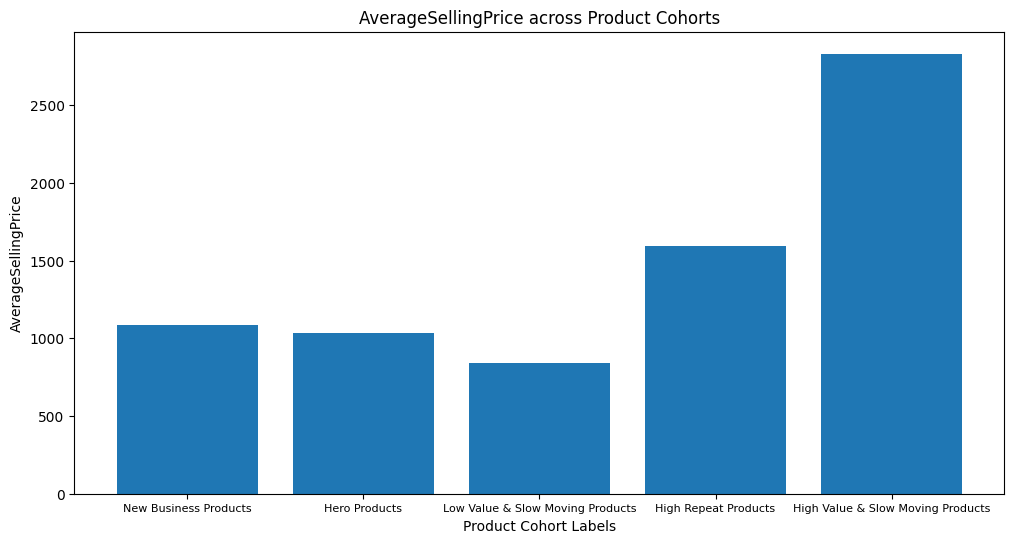

In [310]:
column_to_plot = 'AverageSellingPrice'
x_labels = p1['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, p1[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

In [17]:
# #Visualization of cohorts with key parameters as axises
# fig = plt.figure(figsize = (15, 15))
# ax = plt.axes(projection ="3d")
# size=segstats['Users']*.05
# # Creating plot
# ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
# plt.title("Product Cohort Distribution")
# ax.set_xlabel('CartPenetration', fontweight ='bold')
# ax.set_ylabel('NewUserRatio', fontweight ='bold')
# ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
# for i in range(len(segstats)):
#      ax.text(segstats['CartPenetration'][i],
#                segstats['NewUserRatio'][i],
#              segstats['AverageSellingPrice'][i],
#                segstats['Product Cohort Lables'][i],
#                horizontalalignment='left',
#                rotation=25, wrap=True,
#                verticalalignment='center',
#                size='medium', color='black')
